In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### This notebook was created to find the isolates in rollingDB that have the same SNPs identified from in-host SNP analysis

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy

from collections import Counter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import warnings
warnings.filterwarnings("ignore", module="matplotlib")

In [3]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

### Load annotation for *in-host* SNPs

In [4]:
in_host_SNPs_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70_intergenic_annotated_with_allele1_allele2_info.pkl')

In [5]:
in_host_SNPs_DF.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change,allele_1,allele_2,alt_AF_1,alt_AF_2,altAF2_minus_altAF1
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D,C,G,0.0,1.0,1.0
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S,T,G,0.0,1.0,1.0
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T,A,G,0.0,1.0,1.0
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T,T,A,0.0,1.0,1.0
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L,A,G,0.0,1.0,1.0


In [6]:
np.shape(in_host_SNPs_DF)

(175, 17)

#### Subest to 142/175 SNPs in which the frequency of the Alternate Allele increased over time (Reference Allele > Alternate Allele)

In [7]:
in_host_SNPs_DF = in_host_SNPs_DF[in_host_SNPs_DF.altAF2_minus_altAF1 > 0]

In [8]:
np.shape(in_host_SNPs_DF)

(142, 17)

Save a list of H37Rv Reference Positions that in-host SNPs occur at to filter Genotypes Matrix below

In [9]:
in_host_ref_positions_list = list(set(in_host_SNPs_DF.ref_position))

Save a list of specific mutations observed in-host to filter SNPs called in rollingDB later

In [10]:
in_host_SNPs_mut_keys_list = [str(ref_pos_i) + '_' + alt_allele_i for ref_pos_i , alt_allele_i in zip(in_host_SNPs_DF.ref_position , in_host_SNPs_DF.alt_allele)]

### Load SNPs from scraping Luca's DB (Genotypes Matrix) 

In [11]:
#load SNP annotation file (rows of Genotype Matrix)
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/genotypes_matrix_and_tSNE/Genotype_Filtered_2/genotypes_SNP_annotation.pkl')

#load isolate annotation file (columns of Genotypes Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/genotypes_matrix_and_tSNE/Genotype_Filtered_2/genotypes_isolate_annotation.pkl')

#load Genotypes Matrix
genotypes_array = np.load('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/genotypes_matrix_and_tSNE/Genotype_Filtered_2/genotypes_matrix.npy')

#SNP functional annotation
SNP_functional_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/genotypes_matrix_and_tSNE/Genotype_Filtered_2/genotypes_SNP_functional_annotation.pkl')

In [12]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,29,C,[G],[Rv0001],[28],[Essential],[dnaA]
1,31,A,"[C, G]",[Rv0001],[30],[Essential],[dnaA]
2,48,C,[T],[Rv0001],[47],[Essential],[dnaA]
3,64,G,[C],[Rv0001],[63],[Essential],[dnaA]
4,71,C,[T],[Rv0001],[70],[Essential],[dnaA]


In [13]:
np.shape(SNP_annotation_DF)

(128898, 7)

In [14]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,isolate_ID
0,3,1,1,NaN,NaN,SAMN03647419
1,1,1,3,NaN,NaN,SAMN07659096
2,4,1,1,NaN,NaN,SAMEA1119683
3,2,2,1,NaN,NaN,SAMN05576173
4,2,2,1,NaN,NaN,SAMN08612836


In [15]:
np.shape(isolate_annotation_DF)

(20352, 6)

In [16]:
np.shape(genotypes_array)

(128898, 20352)

In [17]:
SNP_functional_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
29_G,29,C,G,Essential,dnaA,Rv0001,29,N,T10S
31_C,31,A,C,Essential,dnaA,Rv0001,31,N,T11P
31_G,31,A,G,Essential,dnaA,Rv0001,31,N,T11A
48_T,48,C,T,Essential,dnaA,Rv0001,48,S,V16V
64_C,64,G,C,Essential,dnaA,Rv0001,64,N,G22R


## Rule 1A: Filter SNPs - Subset genotypes matrix to SNPs that occur at same sites as *in-host* SNPs

In [18]:
SNPs_to_keep_filter = [ SNP_i_ref_pos in in_host_ref_positions_list for SNP_i_ref_pos in list(SNP_annotation_DF.pos) ]

49 in-host SNP sites detected in Genotypes Matrix

In [19]:
sum(SNPs_to_keep_filter)

49

Filter SNPs annotation DF

In [20]:
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(inplace = True , drop = True)

In [21]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,6742,A,"[C, T]",[Rv0005],[1502],[Antibiotic Resistance],[gyrB]
1,7521,G,[T],[Rv0006],[219],[Antibiotic Resistance],[gyrA]
2,7581,G,"[A, C, T]",[Rv0006],[279],[Antibiotic Resistance],[gyrA]
3,7582,A,"[C, T, G]",[Rv0006],[280],[Antibiotic Resistance],[gyrA]
4,105060,G,[A],[Rv0095c],[255],[Non-Essential],[Rv0095c]


In [22]:
np.shape(SNP_annotation_DF)

(49, 7)

Filter Genotypes Matrix

In [23]:
genotypes_array = genotypes_array[SNPs_to_keep_filter , :]

In [24]:
genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 9, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [1, 9, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2]])

In [25]:
np.shape(genotypes_array)

(49, 20352)

### Reformat Data: format SNP (with alternate call) per Isolate into a DF with each row corresponding to a specific SNP called in an isolate

In [26]:
base_to_code_map = {'A':0 , 'C':1 , 'G':2 , 'T':3}
base_to_code_map_r = {0:'A' , 1:'C' , 2:'G' , 3:'T'}

In [27]:
SNP_i_from_Lucas_DF_list = []

for SNP_index in SNP_annotation_DF.index:

    #SNP annotation
    SNP_info = SNP_annotation_DF.loc[SNP_index , :]
    SNP_ref_allele_code = base_to_code_map[SNP_info.ref]

    #genotypes for SNP
    SNP_genotypes = genotypes_array[SNP_index , :]

    #filter for isolates that have a missing call at this position
    isolates_with_missing_call_for_SNP_filter = list(SNP_genotypes == 9)

    #filter for isolates that support the reference allele at this position
    isolates_support_ref_allele_for_SNP_filter = list(SNP_genotypes == SNP_ref_allele_code)

    #filter for isolates to keep - isolates with good call that support an alternate allele
    isolate_calls_to_keep = [(not missing_call) and (not ref_allele) for missing_call , ref_allele in zip(isolates_with_missing_call_for_SNP_filter , isolates_support_ref_allele_for_SNP_filter)]

    #subset Isolates Annotation and Genotypes to Isolates with alternate call
    SNP_genotypes_isolates_support_alt_allele_for_SNP = SNP_genotypes[isolate_calls_to_keep]
    SNP_genotypes_isolates_support_alt_allele_for_SNP = [base_to_code_map_r[allele_code] for allele_code in SNP_genotypes_isolates_support_alt_allele_for_SNP] #convert to nucleotides

    isolate_annotation_isolates_support_alt_allele_for_SNP = isolate_annotation_DF[isolate_calls_to_keep]
    isolate_annotation_isolates_support_alt_allele_for_SNP.reset_index(inplace = True , drop = True)

    #combine (SNP info) , (genotypes for isolates w/ alt allele) , isolate annotation into 1 DF
    SNP_i_from_Lucas_DB_df = pd.DataFrame()
    isolate_ID_list = isolate_annotation_isolates_support_alt_allele_for_SNP.isolate_ID
    ref_pos_list = [SNP_info.pos] * np.shape(isolate_annotation_isolates_support_alt_allele_for_SNP)[0]
    ref_allele_list = [SNP_info.ref] * np.shape(isolate_annotation_isolates_support_alt_allele_for_SNP)[0]
    gene_id_list = [SNP_info.gene_id[0]] * np.shape(isolate_annotation_isolates_support_alt_allele_for_SNP)[0]
    gene_category_list = [SNP_info.gene_category[0]] * np.shape(isolate_annotation_isolates_support_alt_allele_for_SNP)[0]
    symbol_list = [SNP_info.gene_name[0]] * np.shape(isolate_annotation_isolates_support_alt_allele_for_SNP)[0]

    #get functional SNP annotation (will change per isolate depending on the alternate allele)
    genomic_coord_list = [ SNP_functional_annotation_DF.loc[str(pos_i) + '_' + alt_allele_i , 'gene_pos'] for pos_i , alt_allele_i in zip(ref_pos_list , SNP_genotypes_isolates_support_alt_allele_for_SNP)]
    SNP_type_list = [ SNP_functional_annotation_DF.loc[str(pos_i) + '_' + alt_allele_i , 'SNP_type'] for pos_i , alt_allele_i in zip(ref_pos_list , SNP_genotypes_isolates_support_alt_allele_for_SNP)]
    AA_change_list = [ SNP_functional_annotation_DF.loc[str(pos_i) + '_' + alt_allele_i , 'AA_change'] for pos_i , alt_allele_i in zip(ref_pos_list , SNP_genotypes_isolates_support_alt_allele_for_SNP)]

    #create DataFrame with information about this SNP for each isolate with alt allele
    SNP_i_from_Lucas_DB_df.loc[: , 'isolate_ID'] = isolate_ID_list
    SNP_i_from_Lucas_DB_df.loc[: , 'ref_position'] = ref_pos_list
    SNP_i_from_Lucas_DB_df.loc[: , 'genomic_coord'] = genomic_coord_list
    SNP_i_from_Lucas_DB_df.loc[: , 'ref_allele'] = ref_allele_list
    SNP_i_from_Lucas_DB_df.loc[: , 'alt_allele'] = SNP_genotypes_isolates_support_alt_allele_for_SNP
    SNP_i_from_Lucas_DB_df.loc[: , 'gene_id'] = gene_id_list
    SNP_i_from_Lucas_DB_df.loc[: , 'Gene_Category'] = gene_category_list
    SNP_i_from_Lucas_DB_df.loc[: , 'symbol'] = symbol_list
    SNP_i_from_Lucas_DB_df.loc[: , 'SNP_type'] = SNP_type_list
    SNP_i_from_Lucas_DB_df.loc[: , 'AA_change'] = AA_change_list

    #merge DataFrame with SNP info with the DataFrame with the Isolate info
    SNP_i_from_Lucas_DB_df = SNP_i_from_Lucas_DB_df.merge(isolate_annotation_isolates_support_alt_allele_for_SNP , how = 'right' , on = 'isolate_ID')
    
    #append to list of DataFrames for each SNP
    SNP_i_from_Lucas_DF_list.append(SNP_i_from_Lucas_DB_df)
    
#append all DataFrames (1 for each SNP site) into one master DF
SNPs_from_Lucas_DB_df = pd.concat(SNP_i_from_Lucas_DF_list)
SNPs_from_Lucas_DB_df.reset_index(inplace = True , drop = True)

In [28]:
SNPs_from_Lucas_DB_df.head()

,isolate_ID,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5
0,SAMEA1404001,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN
1,SAMN10961345,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN
2,SAMEA5626316,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,3,NaN,NaN,NaN,NaN
3,SAMN08708189,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN
4,SAMN08708356,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN


In [29]:
SNPs_from_Lucas_DB_df.tail()

,isolate_ID,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5
13955,SAMN08629356,4407979,224,G,A,Rv3919c,Antibiotic Resistance,gid,N,P75L,4,8,NaN,NaN,NaN
13956,SAMN06092098,4407979,224,G,C,Rv3919c,Antibiotic Resistance,gid,N,P75R,2,2,2,NaN,NaN
13957,SAMEA3432786,4407979,224,G,C,Rv3919c,Antibiotic Resistance,gid,N,P75R,3,NaN,NaN,NaN,NaN
13958,SAMEA2535209,4407979,224,G,C,Rv3919c,Antibiotic Resistance,gid,N,P75R,4,2,2,1,NaN
13959,SAMN08629302,4407979,224,G,A,Rv3919c,Antibiotic Resistance,gid,N,P75L,3,NaN,NaN,NaN,NaN


In [30]:
np.shape(SNPs_from_Lucas_DB_df)

(13960, 15)

## Rule 1B: Retain only SNP calls in which the Alternate Allele matches the Alternate Allele called *in-host*

This is needed since some SNP sites are not biallelic

In [31]:
SNPs_from_Lucas_DB_to_keep_filter = []

for SNP_i_ref_pos , SNP_i_alt_allele in zip(SNPs_from_Lucas_DB_df.ref_position , SNPs_from_Lucas_DB_df.alt_allele):
    
    if str(SNP_i_ref_pos) + '_' + SNP_i_alt_allele in in_host_SNPs_mut_keys_list:
        
        SNPs_from_Lucas_DB_to_keep_filter.append(True)
        
    else:
        
        SNPs_from_Lucas_DB_to_keep_filter.append(False)
        
SNPs_from_Lucas_DB_df = SNPs_from_Lucas_DB_df[SNPs_from_Lucas_DB_to_keep_filter]
SNPs_from_Lucas_DB_df.reset_index(inplace = True , drop = True) #reset index

In [32]:
SNPs_from_Lucas_DB_df.head()

,isolate_ID,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5
0,SAMEA1404001,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN
1,SAMN10961345,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN
2,SAMEA5626316,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,3,NaN,NaN,NaN,NaN
3,SAMN08708189,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN
4,SAMN08708356,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,2,2,1,NaN,NaN


In [33]:
np.shape(SNPs_from_Lucas_DB_df)

(11973, 15)

#### Output DataFrame of all SNPs picked up from RollingDB and used for analysis for Supplementary Table

In [34]:
SNPs_from_Lucas_DB_df.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/rolling_DB_scrape/SNPs_from_rollingDB.csv')

### Count the number of each global lineage represented in the Luca's isolate pool

In [35]:
global_lineage_count = pd.Series( Counter( isolate_annotation_DF.lineage_1 ) )
global_lineage_count = global_lineage_count[['1' , '2' , '3' , '4' , '5' , '6']]
global_lineage_count.fillna(0.0 , inplace = True)

In [36]:
global_lineage_count

1    2802
2    7000
3    3352
4    7000
5     101
6      97
dtype: int64

In [37]:
int( global_lineage_count.sum() )

20352

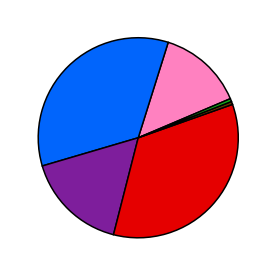

In [38]:
pie_slice_proportions = []
labels = []
colors = []

for global_lineage_i in global_lineage_count.index:
    
    proportion = float(global_lineage_count[global_lineage_i]) / float(global_lineage_count.sum())
    pie_slice_proportions.append(proportion)
    labels.append(global_lineage_i)
    
    if global_lineage_i == '1':
        colors.append('xkcd:pink')
    if global_lineage_i == '2':
        colors.append('xkcd:bright blue')
    if global_lineage_i == '3':
        colors.append('xkcd:purple')
    if global_lineage_i == '4':
        colors.append('xkcd:red')
    if global_lineage_i == '5':
        colors.append('xkcd:brown')
    if global_lineage_i == '6':
        colors.append('xkcd:green')
        
# Make square figures and axes
the_grid = GridSpec(1, 1)

fig, ax = plt.subplots()

wedges, texts = ax.pie(pie_slice_proportions, shadow=False , colors = colors , wedgeprops = {'linewidth': 12 } , labeldistance = 1.1 , startangle = 23)

fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.tight_layout()

for w in wedges:
    w.set_linewidth(1.5)
    w.set_edgecolor('black')
    
#for text in texts:
#    text.set_rotation(0)

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/scraping_rollingDB/Global_Lineage_Distribution_across_all_isolates.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
plt.show()

### Count the number of SNPs that occur for each individual SNP site (identified from *in-host* SNPs)

#### Add a column to specify specific SNP Reference Position and Alterante Allele

In [39]:
SNPs_from_Lucas_DB_df['ref_position_and_alt_allele'] = [ (str(int(ref_pos)) + '_' + alt_allele) for ref_pos, alt_allele in zip(list( SNPs_from_Lucas_DB_df.ref_position ) , list( SNPs_from_Lucas_DB_df.alt_allele ) )]

## Rule 2A: Look for SNPs that were present in $\ge 3$ global lineages

In [40]:
SNPs_present_in_multiple_lineages = []

for SNP_i in list(set(SNPs_from_Lucas_DB_df.ref_position_and_alt_allele)):
    
    lineage_call_count_for_SNPs_in_rollingDB = pd.Series( Counter( SNPs_from_Lucas_DB_df[SNPs_from_Lucas_DB_df.ref_position_and_alt_allele == SNP_i].lineage_1 ) )
    
    num_global_lineages = len(lineage_call_count_for_SNPs_in_rollingDB)
    
    if num_global_lineages >= 3:
        
        SNPs_present_in_multiple_lineages.append(SNP_i)

Create DataFrame to hold information for SNPs present in multiple global lineages

In [41]:
#drop 'duplicate' rows in longitudinal SNPs df (SNPs that were present in > than 1 subject)
codon_SNPs_no_repeat_SNPs = SNPs_from_Lucas_DB_df[ [not duplicate_SNP for duplicate_SNP in SNPs_from_Lucas_DB_df.duplicated(subset = ['genomic_coord' , 'ref_allele' , 'alt_allele' , 'gene_id' , 'ref_position_and_alt_allele'], keep = 'first')] ]

#re-index codon SNP df by reference position-alt allele keys
codon_SNPs_reindexed = codon_SNPs_no_repeat_SNPs.set_index('ref_position_and_alt_allele' , drop = True)

#subset df to SNPs that cropped up in multiple global lineages
SNPs_present_in_multiple_lineages_DF = codon_SNPs_reindexed.loc[SNPs_present_in_multiple_lineages , :]

#drop unneccessary columns
SNPs_present_in_multiple_lineages_DF.drop(['isolate_ID' , 'lineage_1' , 'lineage_2' , 'lineage_3' , 'lineage_4', 'lineage_5'] , axis = 1 , inplace = True)

#make ref_position a column
SNPs_present_in_multiple_lineages_DF['ref_position_and_alt_allele'] = SNPs_present_in_multiple_lineages_DF.index 

#sort by reference position
SNPs_present_in_multiple_lineages_DF.sort_values(by = 'ref_position' , ascending = True , inplace = True)

#re-index
SNPs_present_in_multiple_lineages_DF.reset_index(inplace = True , drop = True)

In [42]:
SNPs_present_in_multiple_lineages_DF

,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,ref_position_and_alt_allele
0,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,6742_C
1,7581,280,G,A,Rv0006,Antibiotic Resistance,gyrA,N,D94N,7581_A
2,7582,281,A,G,Rv0006,Antibiotic Resistance,gyrA,N,D94G,7582_G
3,105060,156,G,A,Rv0095c,Non-Essential,Rv0095c,S,D52D,105060_A
4,105063,153,G,A,Rv0095c,Non-Essential,Rv0095c,S,F51F,105063_A
5,760314,508,G,T,Rv0667,Antibiotic Resistance,rpoB,N,V170F,760314_T
6,761139,1333,C,G,Rv0667,Antibiotic Resistance,rpoB,N,H445D,761139_G
7,761140,1334,A,C,Rv0667,Antibiotic Resistance,rpoB,N,H445P,761140_C
8,761277,1471,A,T,Rv0667,Antibiotic Resistance,rpoB,N,I491F,761277_T
9,764819,1450,T,G,Rv0668,Antibiotic Resistance,rpoC,N,W484G,764819_G


### Store the global lineage distribution for each SNP (Alternate Allele)

In [43]:
global_lineage_distribution_for_SNPs = pd.DataFrame( index = SNPs_present_in_multiple_lineages_DF.index , columns = ['1' , '2' , '3' , '4' , '5' , '6'] )

for SNP_i in SNPs_present_in_multiple_lineages_DF.index:
    
    ref_pos_alt_base_i = SNPs_present_in_multiple_lineages_DF.loc[SNP_i , 'ref_position_and_alt_allele']
    
    #this counts the number of each global lineage represented in the isolates that have the SNP
    lineage_call_count_for_SNPs_in_rollingDB = pd.Series( Counter( SNPs_from_Lucas_DB_df[SNPs_from_Lucas_DB_df.ref_position_and_alt_allele == ref_pos_alt_base_i].lineage_1 ) )
    
    #fill in the dataframe that holds distribution
    for global_lineage in global_lineage_distribution_for_SNPs.columns:
        
        try:
            
            global_lineage_distribution_for_SNPs.loc[SNP_i , global_lineage] = lineage_call_count_for_SNPs_in_rollingDB[global_lineage]
            
        except KeyError:
            
            global_lineage_distribution_for_SNPs.loc[SNP_i , global_lineage] = 0.0

Append a column that stores the total number of isolates that SNP was found in

In [44]:
global_lineage_distribution_for_SNPs['num_isolates'] = global_lineage_distribution_for_SNPs.sum(axis = 1)

In [45]:
global_lineage_distribution_for_SNPs.head()

,1,2,3,4,5,6,num_isolates
0,0,15,2,4,0,0,21.0
1,1,79,5,14,0,0,99.0
2,15,380,79,117,0,0,591.0
3,113,162,312,541,4,4,1136.0
4,112,172,291,555,4,4,1138.0


Merge DataFrame that holds SNP information to DF that holds global lineage distribution

In [46]:
SNPs_present_in_multiple_lineages_DF = SNPs_present_in_multiple_lineages_DF.merge(global_lineage_distribution_for_SNPs , how = 'inner' , left_index = True , right_index = True)

In [47]:
SNPs_present_in_multiple_lineages_DF.head()

,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,ref_position_and_alt_allele,1,2,3,4,5,6,num_isolates
0,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,6742_C,0,15,2,4,0,0,21.0
1,7581,280,G,A,Rv0006,Antibiotic Resistance,gyrA,N,D94N,7581_A,1,79,5,14,0,0,99.0
2,7582,281,A,G,Rv0006,Antibiotic Resistance,gyrA,N,D94G,7582_G,15,380,79,117,0,0,591.0
3,105060,156,G,A,Rv0095c,Non-Essential,Rv0095c,S,D52D,105060_A,113,162,312,541,4,4,1136.0
4,105063,153,G,A,Rv0095c,Non-Essential,Rv0095c,S,F51F,105063_A,112,172,291,555,4,4,1138.0


In [48]:
SNPs_present_in_multiple_lineages_DF.tail()

,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,ref_position_and_alt_allele,1,2,3,4,5,6,num_isolates
21,4243217,None,C,T,intergenic,None,None,I,None,4243217_T,8,63,18,49,1,0,139.0
22,4247431,918,G,C,Rv3795,Antibiotic Resistance,embB,N,M306I,4247431_C,8,130,32,118,0,0,288.0
23,4247469,956,A,G,Rv3795,Antibiotic Resistance,embB,N,Y319C,4247469_G,2,26,2,1,0,0,31.0
24,4247729,1216,G,A,Rv3795,Antibiotic Resistance,embB,N,G406S,4247729_A,11,24,11,41,0,0,87.0
25,4407979,224,G,A,Rv3919c,Antibiotic Resistance,gid,N,P75L,4407979_A,2,0,1,2,0,0,5.0


## Rule 2B: Filter for SNPs in which the Alternate Allele is present in at least 1 isolate $\ge 3$ global lineages and *not* present in $> 95\%$ of isolates within those global lineages

#### Get the percentage of isolates (within each global lineage) that supported the alternate allele

In [49]:
SNPs_present_in_multiple_lineages_DF['lin1_prop'] = SNPs_present_in_multiple_lineages_DF.loc[: , '1'].astype(float) / float(global_lineage_count['1'])
SNPs_present_in_multiple_lineages_DF['lin2_prop'] = SNPs_present_in_multiple_lineages_DF.loc[: , '2'].astype(float) / float(global_lineage_count['2'])
SNPs_present_in_multiple_lineages_DF['lin3_prop'] = SNPs_present_in_multiple_lineages_DF.loc[: , '3'].astype(float) / float(global_lineage_count['3'])
SNPs_present_in_multiple_lineages_DF['lin4_prop'] = SNPs_present_in_multiple_lineages_DF.loc[: , '4'].astype(float) / float(global_lineage_count['4'])
SNPs_present_in_multiple_lineages_DF['lin5_prop'] = SNPs_present_in_multiple_lineages_DF.loc[: , '5'].astype(float) / float(global_lineage_count['5'])
SNPs_present_in_multiple_lineages_DF['lin6_prop'] = SNPs_present_in_multiple_lineages_DF.loc[: , '6'].astype(float) / float(global_lineage_count['6'])

In [50]:
SNPs_present_in_multiple_lineages_DF.head()

,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,ref_position_and_alt_allele,...,4,5,6,num_isolates,lin1_prop,lin2_prop,lin3_prop,lin4_prop,lin5_prop,lin6_prop
0,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,6742_C,...,4,0,0,21.0,0.000000,0.002143,0.000597,0.000571,0.000000,0.000000
1,7581,280,G,A,Rv0006,Antibiotic Resistance,gyrA,N,D94N,7581_A,...,14,0,0,99.0,0.000357,0.011286,0.001492,0.002000,0.000000,0.000000
2,7582,281,A,G,Rv0006,Antibiotic Resistance,gyrA,N,D94G,7582_G,...,117,0,0,591.0,0.005353,0.054286,0.023568,0.016714,0.000000,0.000000
3,105060,156,G,A,Rv0095c,Non-Essential,Rv0095c,S,D52D,105060_A,...,541,4,4,1136.0,0.040328,0.023143,0.093079,0.077286,0.039604,0.041237
4,105063,153,G,A,Rv0095c,Non-Essential,Rv0095c,S,F51F,105063_A,...,555,4,4,1138.0,0.039971,0.024571,0.086814,0.079286,0.039604,0.041237


### Retain only SNPs in which the Alternate Allele was present in $ \ge 1$ isolate and  $\le 95 \%$ of isolates within at least **3 global lineages**

In [51]:
global_lineage_array = np.array(['1','2','3','4','5','6'])
multiple_lineage_support_alt_allele_filter = [] #boolean filter that will retain SNPs for which alt allele is called in at least 1 isolate and less than 95% of isolates for at least 3 lineages

for SNP_i in SNPs_present_in_multiple_lineages_DF.index:

    keep_SNP = False
    
    #raw counts
    SNP_alt_allele_global_lineage_num_support = SNPs_present_in_multiple_lineages_DF.loc[SNP_i , ['1','2','3','4','5','6']]
    
    #proportions
    SNP_alt_allele_global_lineage_prop_support = SNPs_present_in_multiple_lineages_DF.loc[SNP_i , ['lin1_prop','lin2_prop','lin3_prop','lin4_prop','lin5_prop','lin6_prop']]
    
    #iterate through each global lineage and see if it supports the alternate allele according to rules
    global_lineages_support_alt_allele = 0
    for lin_i_isolate_count , lin_i_isolate_prop in zip(SNP_alt_allele_global_lineage_num_support , SNP_alt_allele_global_lineage_prop_support):
        
        if (lin_i_isolate_count >= 1) and (lin_i_isolate_prop <= 0.95):
            global_lineages_support_alt_allele += 1
            
    if global_lineages_support_alt_allele >= 3:
            keep_SNP = True

    multiple_lineage_support_alt_allele_filter.append(keep_SNP)

In [52]:
SNPs_present_in_multiple_lineages_DF = SNPs_present_in_multiple_lineages_DF[multiple_lineage_support_alt_allele_filter]
#reset index of subset DF
SNPs_present_in_multiple_lineages_DF.reset_index(drop = True , inplace = True)

In [53]:
SNPs_present_in_multiple_lineages_DF.head()

,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,ref_position_and_alt_allele,...,4,5,6,num_isolates,lin1_prop,lin2_prop,lin3_prop,lin4_prop,lin5_prop,lin6_prop
0,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,6742_C,...,4,0,0,21.0,0.000000,0.002143,0.000597,0.000571,0.000000,0.000000
1,7581,280,G,A,Rv0006,Antibiotic Resistance,gyrA,N,D94N,7581_A,...,14,0,0,99.0,0.000357,0.011286,0.001492,0.002000,0.000000,0.000000
2,7582,281,A,G,Rv0006,Antibiotic Resistance,gyrA,N,D94G,7582_G,...,117,0,0,591.0,0.005353,0.054286,0.023568,0.016714,0.000000,0.000000
3,105060,156,G,A,Rv0095c,Non-Essential,Rv0095c,S,D52D,105060_A,...,541,4,4,1136.0,0.040328,0.023143,0.093079,0.077286,0.039604,0.041237
4,105063,153,G,A,Rv0095c,Non-Essential,Rv0095c,S,F51F,105063_A,...,555,4,4,1138.0,0.039971,0.024571,0.086814,0.079286,0.039604,0.041237


**re-index:** Distribution of Global Lineages within each isolates pool that has SNP

In [54]:
SNPs_present_in_multiple_lineages_DF_reindexed = SNPs_present_in_multiple_lineages_DF.set_index('ref_position_and_alt_allele' , drop = True)

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(SNPs_present_in_multiple_lineages_DF_reindexed)

,ref_position,genomic_coord,ref_allele,alt_allele,gene_id,Gene_Category,symbol,SNP_type,AA_change,1,2,3,4,5,6,num_isolates,lin1_prop,lin2_prop,lin3_prop,lin4_prop,lin5_prop,lin6_prop
ref_position_and_alt_allele,,,,,,,,,,,,,,,,,,,,,,
6742_C,6742,1503,A,C,Rv0005,Antibiotic Resistance,gyrB,N,E501D,0,15,2,4,0,0,21.0,0.000000,0.002143,0.000597,0.000571,0.000000,0.000000
7581_A,7581,280,G,A,Rv0006,Antibiotic Resistance,gyrA,N,D94N,1,79,5,14,0,0,99.0,0.000357,0.011286,0.001492,0.002000,0.000000,0.000000
7582_G,7582,281,A,G,Rv0006,Antibiotic Resistance,gyrA,N,D94G,15,380,79,117,0,0,591.0,0.005353,0.054286,0.023568,0.016714,0.000000,0.000000
105060_A,105060,156,G,A,Rv0095c,Non-Essential,Rv0095c,S,D52D,113,162,312,541,4,4,1136.0,0.040328,0.023143,0.093079,0.077286,0.039604,0.041237
105063_A,105063,153,G,A,Rv0095c,Non-Essential,Rv0095c,S,F51F,112,172,291,555,4,4,1138.0,0.039971,0.024571,0.086814,0.079286,0.039604,0.041237
760314_T,760314,508,G,T,Rv0667,Antibiotic Resistance,rpoB,N,V170F,0,23,1,17,1,0,42.0,0.000000,0.003286,0.000298,0.002429,0.009901,0.000000
761139_G,761139,1333,C,G,Rv0667,Antibiotic Resistance,rpoB,N,H445D,12,64,5,61,1,0,143.0,0.004283,0.009143,0.001492,0.008714,0.009901,0.000000
761140_C,761140,1334,A,C,Rv0667,Antibiotic Resistance,rpoB,N,H445P,2,6,0,4,0,0,12.0,0.000714,0.000857,0.000000,0.000571,0.000000,0.000000
761277_T,761277,1471,A,T,Rv0667,Antibiotic Resistance,rpoB,N,I491F,2,8,3,45,0,0,58.0,0.000714,0.001143,0.000895,0.006429,0.000000,0.000000


Output DF as CSV

In [56]:
SNPs_present_in_multiple_lineages_DF_reindexed.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/rolling_DB_scrape/SNPs_in_multiple_global_lineages.csv')

In [57]:
np.shape(SNPs_present_in_multiple_lineages_DF_reindexed)

(26, 22)